# Import All Necessary Library

Pada bagian ini, saya mengimpor beberapa library yang dibutuhkan dalam proyek ini:

- `pandas`: Untuk manipulasi dan analisis data.
- `matplotlib.pyplot`: Untuk visualisasi data dalam bentuk grafik.
- `numpy`: Untuk operasi numerik dan array.
- `MinMaxScaler` dari `sklearn.preprocessing`: Untuk melakukan normalisasi data agar berada pada skala 0-1.
- `mean_squared_error`, `mean_absolute_error` dari `sklearn.metrics`: Untuk mengevaluasi performa model dengan mengukur seberapa besar error dari hasil prediksi.
- `Sequential`, `LSTM`, dan `Dense` dari `tensorflow.keras`: Untuk membangun arsitektur model LSTM yang digunakan dalam peramalan harga saham.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Data Preparation

Karena proyek ini dijalankan di Google Colab, saya melakukan mounting Google Drive agar bisa mengakses file dataset yang tersimpan di dalam Drive. Dengan perintah `drive.mount('/content/drive')`, saya dapat membaca dan menyimpan file langsung dari folder Drive yang sudah terhubung.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pada tahap ini, saya memuat dataset harga saham BBNI dari file CSV yang tersimpan di Google Drive. Data dimuat menggunakan `pandas.read_csv()` dengan parameter `index_col=0` dan `parse_dates=True` agar kolom tanggal dijadikan sebagai index bertipe datetime.

Dataset ini memuat informasi harga saham harian seperti:
- `Open`: Harga pembukaan
- `High`: Harga tertinggi
- `Low`: Harga terendah
- `Close`: Harga penutupan
- `Volume`: Jumlah saham yang diperdagangkan

In [ ]:
# Load Data
data = pd.read_csv('/content/drive/MyDrive/Dataset/BBNI_stock_data.csv', index_col=0, parse_dates=True)
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,647.517395,658.905885,644.263511,647.517395,17285826
2010-01-05,647.517395,658.905885,644.263511,647.517395,31016809
2010-01-06,644.263550,650.771277,641.009707,644.263550,32037904
2010-01-07,641.009705,650.771274,634.502019,641.009705,21151852
2010-01-08,641.009705,647.517432,637.755862,641.009705,12106513


Pada bagian ini, saya hanya mengambil kolom `Close` dari dataset, karena kolom ini merepresentasikan harga penutupan saham harian dan akan digunakan sebagai target utama dalam proses peramalan (forecasting) harga saham.

Harga penutupan dianggap sebagai representasi nilai saham yang paling stabil untuk dianalisis dalam time series.

In [ ]:
# Select the 'Close' column for stock price prediction
close_prices = data[['Close']]

Pada tahap ini, saya memvisualisasikan tren harga penutupan (closing price) saham BBNI dari tahun 2010 hingga data terakhir. Visualisasi ini membantu dalam memahami pola pergerakan harga saham secara historis, termasuk tren naik/turun, volatilitas, dan potensi seasonality.

Selain itu, titik merah pada grafik menunjukkan harga penutupan terakhir yang tersedia dalam dataset, lengkap dengan label angkanya untuk memberikan informasi terkini secara langsung.

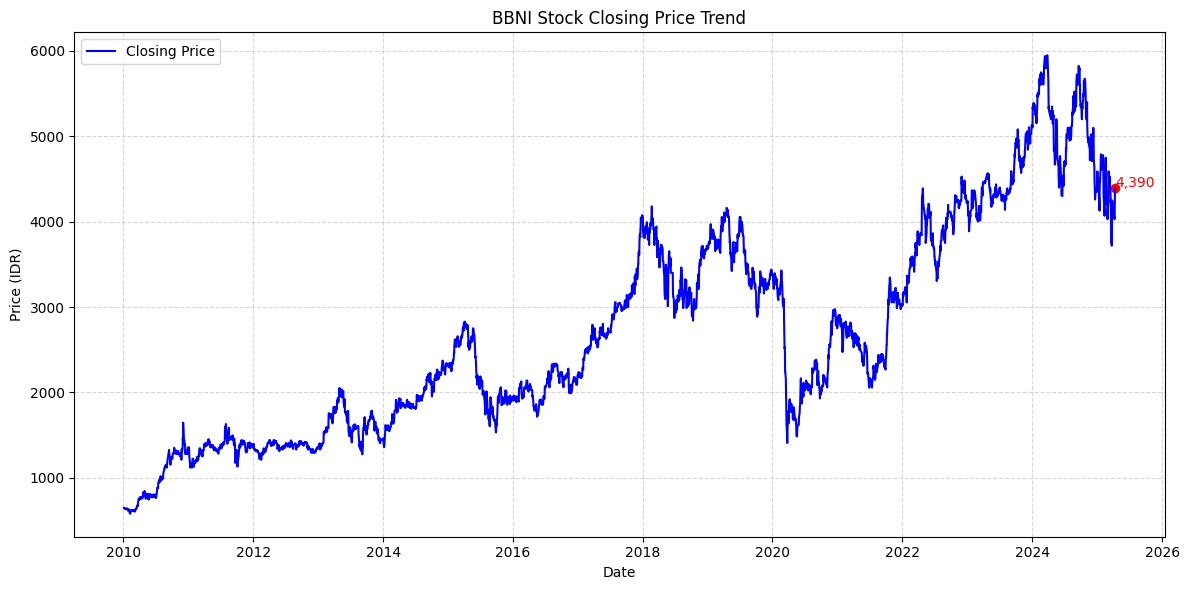

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(close_prices, label='Closing Price', color='blue')
last_price = close_prices.iloc[-1].values[0]
last_date = close_prices.index[-1]
plt.scatter(last_date, last_price, color='red')
plt.text(last_date, last_price + 20, f'{last_price:,.0f}', color='red')
plt.title('BBNI Stock Closing Price Trend')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Preprocessing

Sebelum data digunakan untuk melatih model, saya melakukan normalisasi terhadap nilai harga penutupan menggunakan `MinMaxScaler`. Normalisasi ini mengubah skala data ke rentang 0 hingga 1, yang penting untuk mempercepat proses pelatihan model dan meningkatkan performa, terutama pada model berbasis neural network seperti LSTM.

Proses ini memastikan bahwa perbedaan skala antar data tidak memengaruhi hasil prediksi.

In [ ]:
# Data normalization using MinMaxScaler to normalize the data in the range 0–1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

scaled_data = pd.DataFrame(scaled_data, columns=close_prices.columns, index=close_prices.index)
scaled_data.head()

,Close
Date,
2010-01-04,0.012723
2010-01-05,0.012723
2010-01-06,0.012117
2010-01-07,0.011511
2010-01-08,0.011511


Di tahap ini, saya mengubah data harga penutupan yang sudah dinormalisasi menjadi format time series yang cocok untuk model LSTM.

Saya menggunakan pendekatan sliding window, di mana:
- `n_past = 60` artinya model akan melihat 60 hari terakhir sebagai input (`X`)
- dan memprediksi harga di hari ke-61 sebagai output (`y`)

Proses ini dilakukan untuk seluruh data, menghasilkan pasangan input-output yang siap digunakan untuk pelatihan model prediktif.

In [ ]:
# Create time series data
X, y = [], []
n_past = 60

for i in range(n_past, len(scaled_data)):
    X.append(scaled_data.iloc[i - n_past:i])
    y.append(scaled_data.iloc[i])

X, y = np.array(X), np.array(y)

# Create LSTM Model

Pada tahap ini, saya membuat model LSTM untuk memprediksi harga masa depan berdasarkan data historis.

1. **Membuat Model**:
    - Saya menggunakan `Sequential()` untuk membangun model neural network secara berurutan.
    - Model pertama menambahkan layer LSTM dengan 64 unit dan `return_sequences=True`, yang memungkinkan output dari LSTM pertama berupa urutan data (3D) untuk diteruskan ke layer LSTM kedua.
    - Model kedua menambahkan layer LSTM kedua dengan 32 unit yang menghasilkan output berupa data 2D.
    - Kemudian, saya menambahkan layer `Dense(1)` yang memiliki satu neuron output untuk masalah regresi (prediksi harga).

2. **Mengkompilasi Model**:
    - Menggunakan optimizer 'adam', yang sering digunakan karena kemampuannya yang baik dalam optimisasi parameter jaringan.
    - Menggunakan loss function 'mean_squared_error', yang cocok untuk masalah regresi, karena ingin meminimalkan perbedaan kuadrat antara hasil prediksi dan nilai sebenarnya.

3. **Melatih Model**:
    - Saya melatih model menggunakan data `X` (input) dan `y` (output) selama 20 epoch dengan ukuran batch 32. Proses ini akan mempengaruhi bagaimana model belajar dan menyesuaikan bobotnya untuk memprediksi harga dengan lebih akurat.

In [ ]:
# Create Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(32))
model.add(Dense(1))

# Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train Model
model.fit(X, y, epochs=20, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0301
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 6.0741e-04
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 6.4431e-04
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 6.1180e-04
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 5.7401e-04
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 4.5868e-04
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 4.5929e-04
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 4.3660e-04
Epoch 9/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 4.2363e-04
Epoch 10/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 3.6686e-04
Epoch 11/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 4.0458e-04
Epoch 12/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 3.9907e-04
Epoch 13/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 3.3708e-04
Epoch 14/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - los

Pada proses pelatihan model, terlihat penurunan yang konsisten dalam nilai *loss* dari 0.0301 pada epoch pertama hingga 2.4473e-04 pada epoch terakhir. Penurunan yang cepat terjadi pada epoch awal, diikuti dengan penurunan yang lebih lambat setelah epoch ke-10, menunjukkan model semakin mendekati solusi optimal.

# Prediction

Pada bagian ini, saya mengambil 60 hari terakhir dari data yang sudah dinormalisasi (`scaled_data[-60:]`) sebagai input untuk prediksi model. Data ini kemudian diubah bentuknya menggunakan `reshape(1, 60, 1)` agar sesuai dengan format input yang dibutuhkan oleh model LSTM, yaitu (batch_size, timesteps, features).

In [ ]:
last_60_days = scaled_data[-60:]
future_input = last_60_days.values.reshape(1, 60, 1)

Pada bagian ini, saya menggunakan model untuk memprediksi harga selama 10 hari ke depan:
1. Loop dilakukan sebanyak 10 kali, masing-masing untuk satu hari prediksi.
2. Setiap prediksi (`pred`) dihasilkan oleh model, kemudian ditambahkan ke dalam daftar `future_predictions`.
3. Input untuk prediksi berikutnya diperbarui dengan menambahkan prediksi terbaru dan menggeser data sebelumnya.
4. Setelah seluruh prediksi dihasilkan, hasilnya dikembalikan ke skala asli menggunakan `scaler.inverse_transform()` agar bisa dibandingkan dengan nilai harga asli.


In [ ]:
future_predictions = []

for _ in range(10):  # Prediction for the next 10 days
    pred = model.predict(future_input)[0]
    future_predictions.append(pred)
    future_input = np.append(future_input[:, 1:, :], [[pred]], axis=1)

future_predictions = scaler.inverse_transform(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Pada bagian ini, saya menyusun harga prediksi untuk 10 hari ke depan dan menggabungkannya dengan harga historis untuk memvisualisasikan hasil prediksi:
1. **Mengambil harga dan tanggal terakhir**: Saya mengambil harga penutupan terakhir dan tanggal terakhir dari data historis.
2. **Menentukan tanggal dan harga prediksi**: Saya membuat rentang tanggal untuk 10 hari ke depan dan mengambil harga prediksi pada hari ke-10.
3. **Menyusun data untuk plotting**: Data harga historis dan prediksi digabungkan, kemudian disusun dalam format DataFrame untuk mempermudah visualisasi.
4. **Plotting**: Menggunakan `matplotlib`, saya menampilkan grafik harga historis (dengan warna biru) dan prediksi harga (dengan warna oranye), serta menandai titik awal dan akhir prediksi.

Grafik ini memberikan gambaran jelas tentang harga historis dan prediksi untuk 10 hari ke depan.

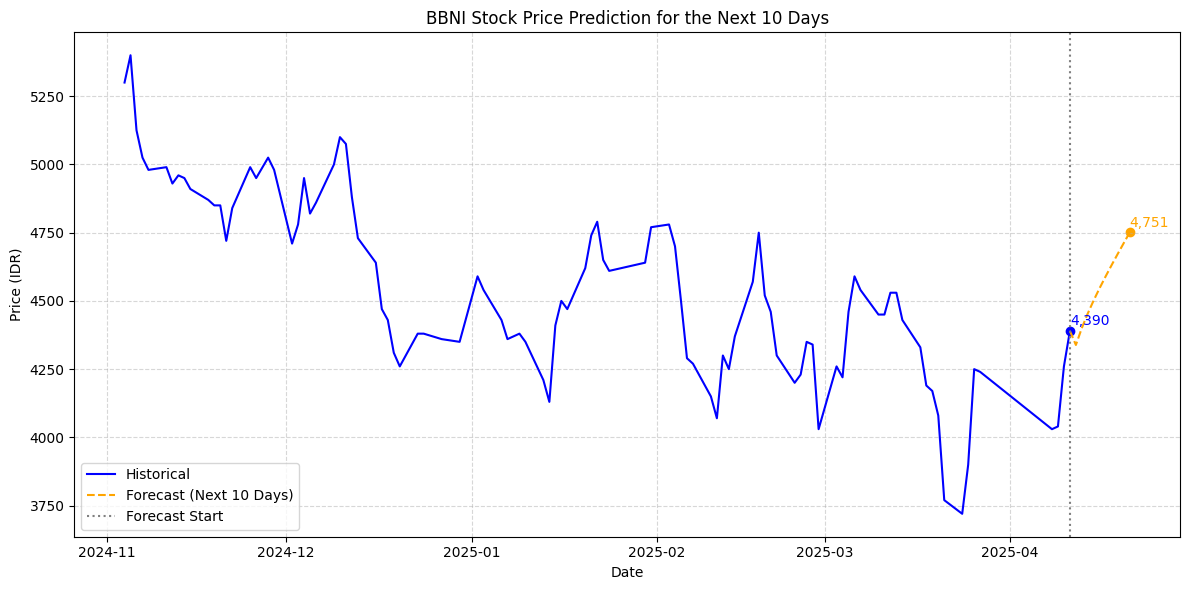

In [ ]:
# Get the last price and date
last_known_date = close_prices.index[-1]
last_known_price = close_prices.iloc[-1]['Close']

# Predicted price on day 10
future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=10)
predicted_last_date = future_dates[-1]
predicted_last_price = future_predictions[-1][0]

# Combine to plot
connected_forecast = [last_known_price]
connected_forecast.extend(future_predictions.flatten())
combined_dates = [last_known_date]
combined_dates.extend(future_dates)
combined_df = pd.DataFrame(connected_forecast, index=combined_dates, columns=['Connected Forecast'])

# Plotting
plt.figure(figsize=(12,6))
plt.plot(close_prices[-100:], label='Historical', color='blue')
plt.plot(combined_df, label='Forecast (Next 10 Days)', color='orange', linestyle='--')
plt.axvline(x=last_known_date, color='gray', linestyle=':', label='Forecast Start')
plt.scatter(last_known_date, last_known_price, color='blue')
plt.text(last_known_date, last_known_price + 20, f'{last_known_price:,.0f}', color='blue')
plt.scatter(predicted_last_date, predicted_last_price, color='orange')
plt.text(predicted_last_date, predicted_last_price + 20, f'{predicted_last_price:,.0f}', color='orange')
plt.title('BBNI Stock Price Prediction for the Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Evaluation

Pada bagian ini, saya membagi data menjadi data pelatihan dan data pengujian, kemudian melakukan evaluasi terhadap prediksi model:
1. **Pembagian Data**: Data dibagi menjadi 80% untuk pelatihan dan 20% untuk pengujian. Data uji diambil dari 60 hari terakhir.
2. **Persiapan Data Uji**: Data uji diolah dengan menggunakan pendekatan sliding window untuk mempersiapkan input dan output yang sesuai dengan format yang dibutuhkan oleh model.
3. **Prediksi pada Data Uji**: Model digunakan untuk memprediksi harga pada data uji.
4. **Transformasi Kembali dan Penghitungan Metri**: Prediksi dan harga aktual dikembalikan ke skala asli menggunakan `scaler.inverse_transform()` dan dihitung beberapa metrik evaluasi seperti MSE, RMSE, MAE, dan MAPE untuk menilai performa model.

Hasil evaluasi menunjukkan bahwa model memiliki MAPE sebesar 2.35%, yang berarti prediksi model cukup akurat.

In [ ]:
# Split data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - n_past:]

# Prepare test data
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data.iloc[i - n_past:i])
    y_test.append(test_data.iloc[i])

X_test, y_test = np.array(X_test), np.array(y_test)

test_dates = test_data.index[n_past:]

# Predict on test data
predicted_test = model.predict(X_test)

# Inverse transform predictions and actual values
predicted_prices = scaler.inverse_transform(predicted_test)
actual_prices = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

# Print all
print(f"Mean Squared Error (MSE) on Test Set: {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Mean Squared Error (MSE) on Test Set: 18230.25
Root Mean Squared Error (RMSE): 135.02
Mean Absolute Error (MAE): 104.95
Mean Absolute Percentage Error (MAPE): 2.35%


Setelah melakukan prediksi pada data uji, berikut adalah hasil evaluasi model berdasarkan beberapa metrik:

- **Mean Squared Error (MSE)**: 18230.25  
  MSE mengukur rata-rata kuadrat perbedaan antara nilai prediksi dan nilai aktual. Nilai ini menunjukkan besarnya kesalahan kuadrat, dengan semakin rendahnya nilai MSE menunjukkan performa yang lebih baik.

- **Root Mean Squared Error (RMSE)**: 135.02  
  RMSE adalah akar kuadrat dari MSE dan memberikan gambaran seberapa jauh prediksi model dari nilai sebenarnya dalam satuan yang sama dengan data asli. Nilai ini menunjukkan tingkat akurasi model dalam prediksi harga.

- **Mean Absolute Error (MAE)**: 104.95  
  MAE mengukur rata-rata perbedaan absolut antara nilai prediksi dan nilai aktual. Semakin rendah nilai MAE, semakin akurat prediksi model.

- **Mean Absolute Percentage Error (MAPE)**: 2.35%  
  MAPE menunjukkan rata-rata persentase kesalahan prediksi model. Nilai 2.35% menunjukkan bahwa model memiliki akurasi yang cukup baik, dengan kesalahan prediksi rata-rata hanya sekitar 2.35%.

Secara keseluruhan, hasil evaluasi menunjukkan bahwa model dapat memprediksi harga dengan akurasi yang baik.

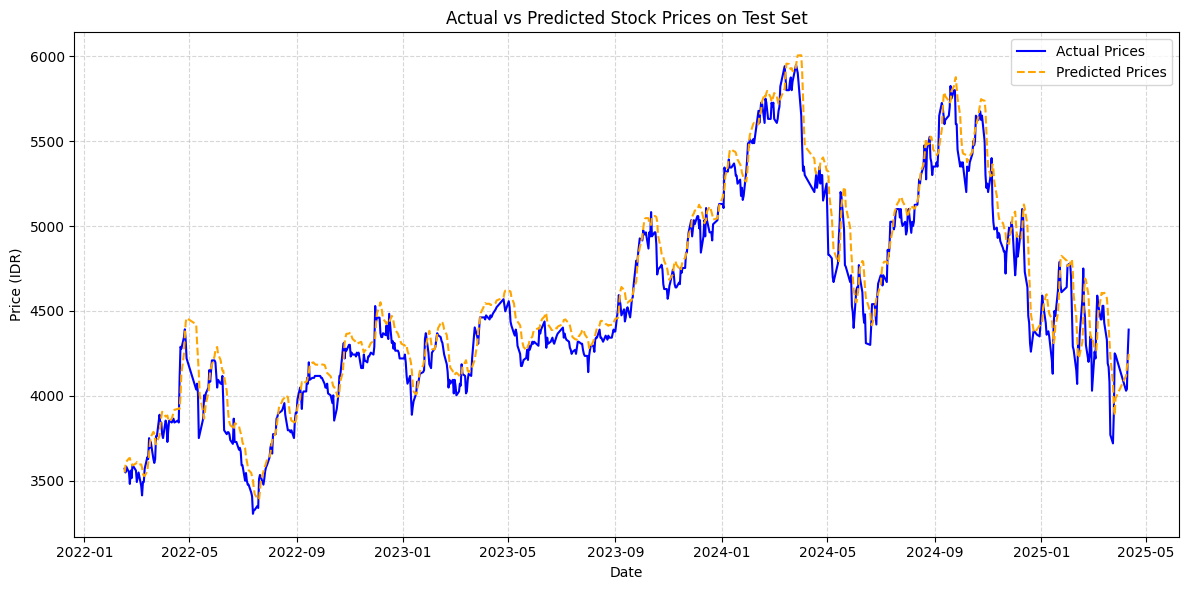

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_prices, label='Actual Prices', color='blue')
plt.plot(test_dates, predicted_prices, label='Predicted Prices', color='orange', linestyle='--')
plt.title('Actual vs Predicted Stock Prices on Test Set')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Pada bagian ini, saya memvisualisasikan perbandingan antara harga aktual dan harga yang diprediksi oleh model pada data uji:
1. **Plotting Harga Aktual dan Prediksi**: Menggunakan `matplotlib`, saya menggambarkan harga aktual (dengan warna biru) dan harga yang diprediksi (dengan warna oranye dan garis putus-putus) sepanjang tanggal pada data uji.


Grafik ini memberikan gambaran jelas tentang seberapa baik model dalam memprediksi harga saham dibandingkan dengan harga yang sebenarnya.